In [1]:
import pandas as pd

In [3]:
df = pd.read_csv('data/ONGB_EvalData_CLEANED.csv')

/var/folders/wt/c9dq7wk56lgb5n1hnwj_0glc0000gn/T/ipykernel_22503/1654161208.py:1: DtypeWarning: Columns (102) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/ONGB_EvalData_CLEANED.csv')


In [4]:
# First, let's explore the data structure
print(f"Dataset shape: {df.shape}")
print(f"\nNumber of students: {df['ANON_ID'].nunique()}")

# Get all AttRate columns
attrate_cols = [col for col in df.columns if col.startswith('AttRate_')]
print(f"\nAttendance Rate columns: {attrate_cols}")

# Check how many students have data for each year
print("\nData availability by year:")
for col in attrate_cols:
    year = col.split('_')[1]
    count = df[col].notna().sum()
    print(f"  {year}: {count} students ({count/len(df)*100:.1f}%)")

Dataset shape: (79460, 143)

Number of students: 79460

Attendance Rate columns: ['AttRate_1718', 'AttRate_1819', 'AttRate_1920', 'AttRate_2021', 'AttRate_2122', 'AttRate_2223', 'AttRate_2324']

Data availability by year:
  1718: 39929 students (50.3%)
  1819: 39579 students (49.8%)
  1920: 38839 students (48.9%)
  2021: 37558 students (47.3%)
  2122: 36153 students (45.5%)
  2223: 36552 students (46.0%)
  2324: 36695 students (46.2%)


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Reshape data from wide to long format for trend analysis
attrate_cols = ['AttRate_1718', 'AttRate_1819', 'AttRate_1920', 'AttRate_2021', 'AttRate_2122', 'AttRate_2223', 'AttRate_2324']
years = ['17-18', '18-19', '19-20', '20-21', '21-22', '22-23', '23-24']

# Create long format dataframe
df_long = df[['ANON_ID'] + attrate_cols].melt(
    id_vars=['ANON_ID'], 
    value_vars=attrate_cols,
    var_name='Year', 
    value_name='AttRate'
)
df_long['Year'] = df_long['Year'].str.replace('AttRate_', '').map(dict(zip([c.split('_')[1] for c in attrate_cols], years)))
df_long = df_long.dropna(subset=['AttRate'])
print(f"Long format shape: {df_long.shape}")
df_long.head(10)

Long format shape: (265305, 3)


,ANON_ID,Year,AttRate
0,1,17-18,0.9722
1,2,17-18,0.9278
3,4,17-18,0.9943
7,8,17-18,0.9778
8,9,17-18,0.9889
9,10,17-18,0.9944
12,13,17-18,0.9833
14,15,17-18,0.9222
15,16,17-18,0.9664
18,19,17-18,0.9389


Yearly Attendance Statistics:
 Year     mean  median      std
17-18 0.935369  0.9661 0.096836
18-19 0.890786  0.9218 0.112387
19-20 0.927066  0.9624 0.114106
20-21 0.916241  0.9833 0.168608
21-22 0.860227  0.9111 0.159691
22-23 0.841605  0.8833 0.137346
23-24 0.889455  0.9333 0.141714


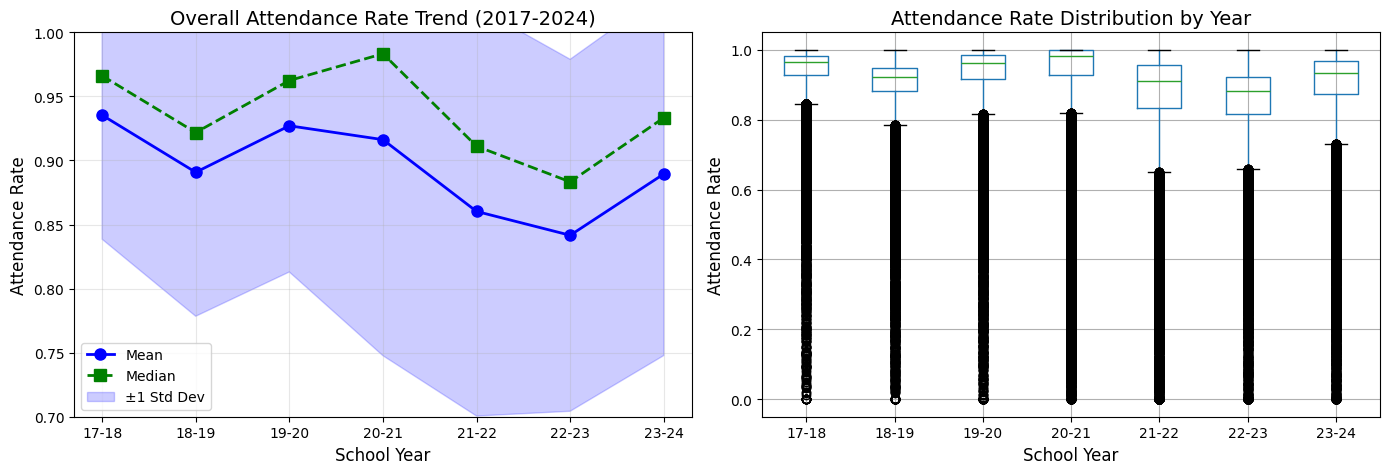

In [6]:
# 1. Overall Trend: Mean Attendance Rate by Year
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Mean attendance rate by year
yearly_stats = df_long.groupby('Year')['AttRate'].agg(['mean', 'median', 'std']).reset_index()
yearly_stats = yearly_stats.sort_values('Year')

ax1 = axes[0]
ax1.plot(yearly_stats['Year'], yearly_stats['mean'], 'b-o', linewidth=2, markersize=8, label='Mean')
ax1.plot(yearly_stats['Year'], yearly_stats['median'], 'g--s', linewidth=2, markersize=8, label='Median')
ax1.fill_between(yearly_stats['Year'], 
                  yearly_stats['mean'] - yearly_stats['std'], 
                  yearly_stats['mean'] + yearly_stats['std'], 
                  alpha=0.2, color='blue', label='±1 Std Dev')
ax1.set_xlabel('School Year', fontsize=12)
ax1.set_ylabel('Attendance Rate', fontsize=12)
ax1.set_title('Overall Attendance Rate Trend (2017-2024)', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0.7, 1.0)

# Show the actual values
print("Yearly Attendance Statistics:")
print(yearly_stats.to_string(index=False))

# Distribution of attendance rates by year (box plot)
ax2 = axes[1]
year_order = ['17-18', '18-19', '19-20', '20-21', '21-22', '22-23', '23-24']
df_long['Year'] = pd.Categorical(df_long['Year'], categories=year_order, ordered=True)
df_long.boxplot(column='AttRate', by='Year', ax=ax2)
ax2.set_xlabel('School Year', fontsize=12)
ax2.set_ylabel('Attendance Rate', fontsize=12)
ax2.set_title('Attendance Rate Distribution by Year', fontsize=14)
plt.suptitle('')  # Remove automatic title

plt.tight_layout()
plt.show()

Students with data in 4+ years: 33495


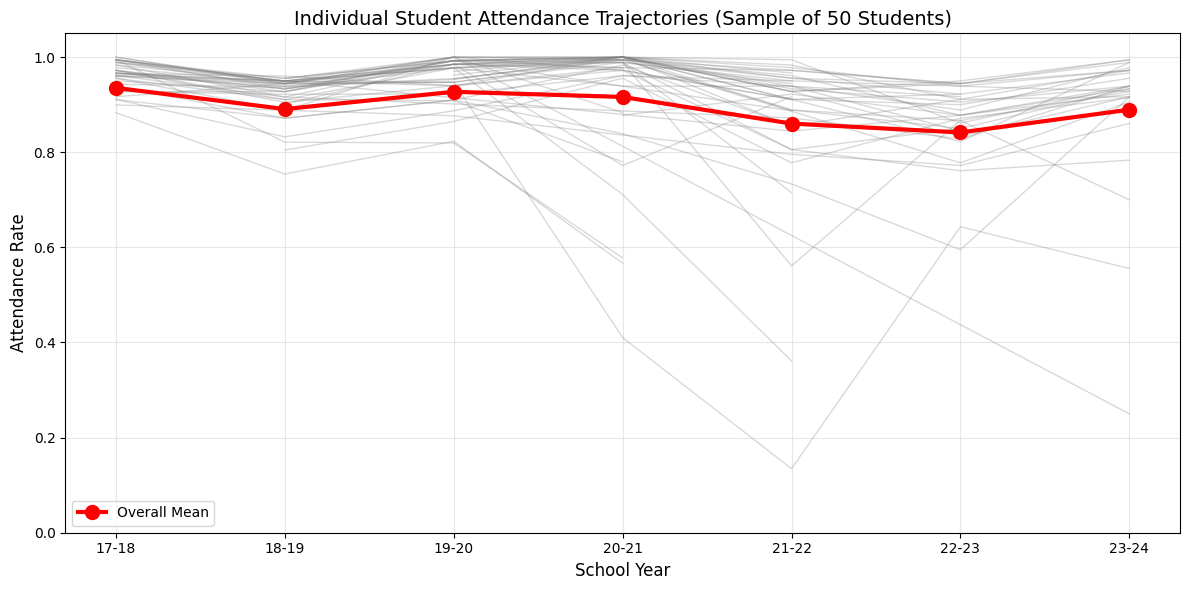

In [13]:
# 2. Individual Student Trajectories - Sample of students with data across multiple years
# Find students with data in at least 4 years
student_year_counts = df_long.groupby('ANON_ID')['Year'].count()
students_multi_year = student_year_counts[student_year_counts >= 4].index.tolist()
print(f"Students with data in 4+ years: {len(students_multi_year)}")

# Sample 50 random students to visualize their trajectories
np.random.seed(42)
sample_students = np.random.choice(students_multi_year, min(50, len(students_multi_year)), replace=False)

# Define correct year order
year_order = ['17-18', '18-19', '19-20', '20-21', '21-22', '22-23', '23-24']

# Create a mapping of year to numeric position for plotting
year_to_num = {year: i for i, year in enumerate(year_order)}

fig, ax = plt.subplots(figsize=(12, 6))

# Plot each student's trajectory using numeric x positions
for student in sample_students:
    student_data = df_long[df_long['ANON_ID'] == student].copy()
    student_data['Year_num'] = student_data['Year'].map(year_to_num)
    student_data = student_data.sort_values('Year_num')
    ax.plot(student_data['Year_num'], student_data['AttRate'], alpha=0.3, linewidth=1, color='gray')

# Overlay the mean trend
mean_trend = df_long.groupby('Year', observed=True)['AttRate'].mean().reindex(year_order)
ax.plot(range(len(year_order)), mean_trend.values, 'r-', linewidth=3, label='Overall Mean', marker='o', markersize=10)

# Set x-axis labels
ax.set_xticks(range(len(year_order)))
ax.set_xticklabels(year_order)
ax.set_xlabel('School Year', fontsize=12)
ax.set_ylabel('Attendance Rate', fontsize=12)
ax.set_title('Individual Student Attendance Trajectories (Sample of 50 Students)', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1.05)
plt.tight_layout()
plt.show()

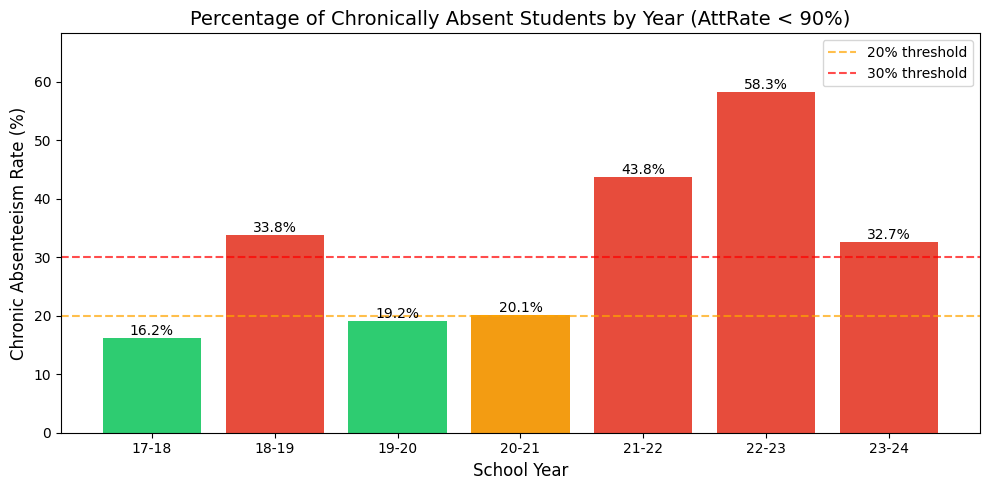


Chronic Absenteeism Rate by Year:
 Year  ChronicAbsent_Pct
17-18          16.248842
18-19          33.808333
19-20          19.161152
20-21          20.131530
21-22          43.758471
22-23          58.262202
23-24          32.680202


In [8]:
# 3. Chronic Absenteeism Rate Trend (students with AttRate < 0.9)
# Calculate the percentage of chronically absent students each year
chronic_threshold = 0.9

chronic_by_year = df_long.groupby('Year', observed=True).apply(
    lambda x: (x['AttRate'] < chronic_threshold).mean() * 100, 
    include_groups=False
).reset_index()
chronic_by_year.columns = ['Year', 'ChronicAbsent_Pct']
chronic_by_year = chronic_by_year.sort_values('Year')

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(chronic_by_year['Year'], chronic_by_year['ChronicAbsent_Pct'], 
               color=['#2ecc71' if x < 20 else '#f39c12' if x < 30 else '#e74c3c' for x in chronic_by_year['ChronicAbsent_Pct']])
ax.set_xlabel('School Year', fontsize=12)
ax.set_ylabel('Chronic Absenteeism Rate (%)', fontsize=12)
ax.set_title('Percentage of Chronically Absent Students by Year (AttRate < 90%)', fontsize=14)
ax.axhline(y=20, color='orange', linestyle='--', alpha=0.7, label='20% threshold')
ax.axhline(y=30, color='red', linestyle='--', alpha=0.7, label='30% threshold')
ax.legend()

# Add value labels on bars
for bar, val in zip(bars, chronic_by_year['ChronicAbsent_Pct']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            f'{val:.1f}%', ha='center', fontsize=10)

ax.set_ylim(0, max(chronic_by_year['ChronicAbsent_Pct']) + 10)
plt.tight_layout()
plt.show()

print("\nChronic Absenteeism Rate by Year:")
print(chronic_by_year.to_string(index=False))

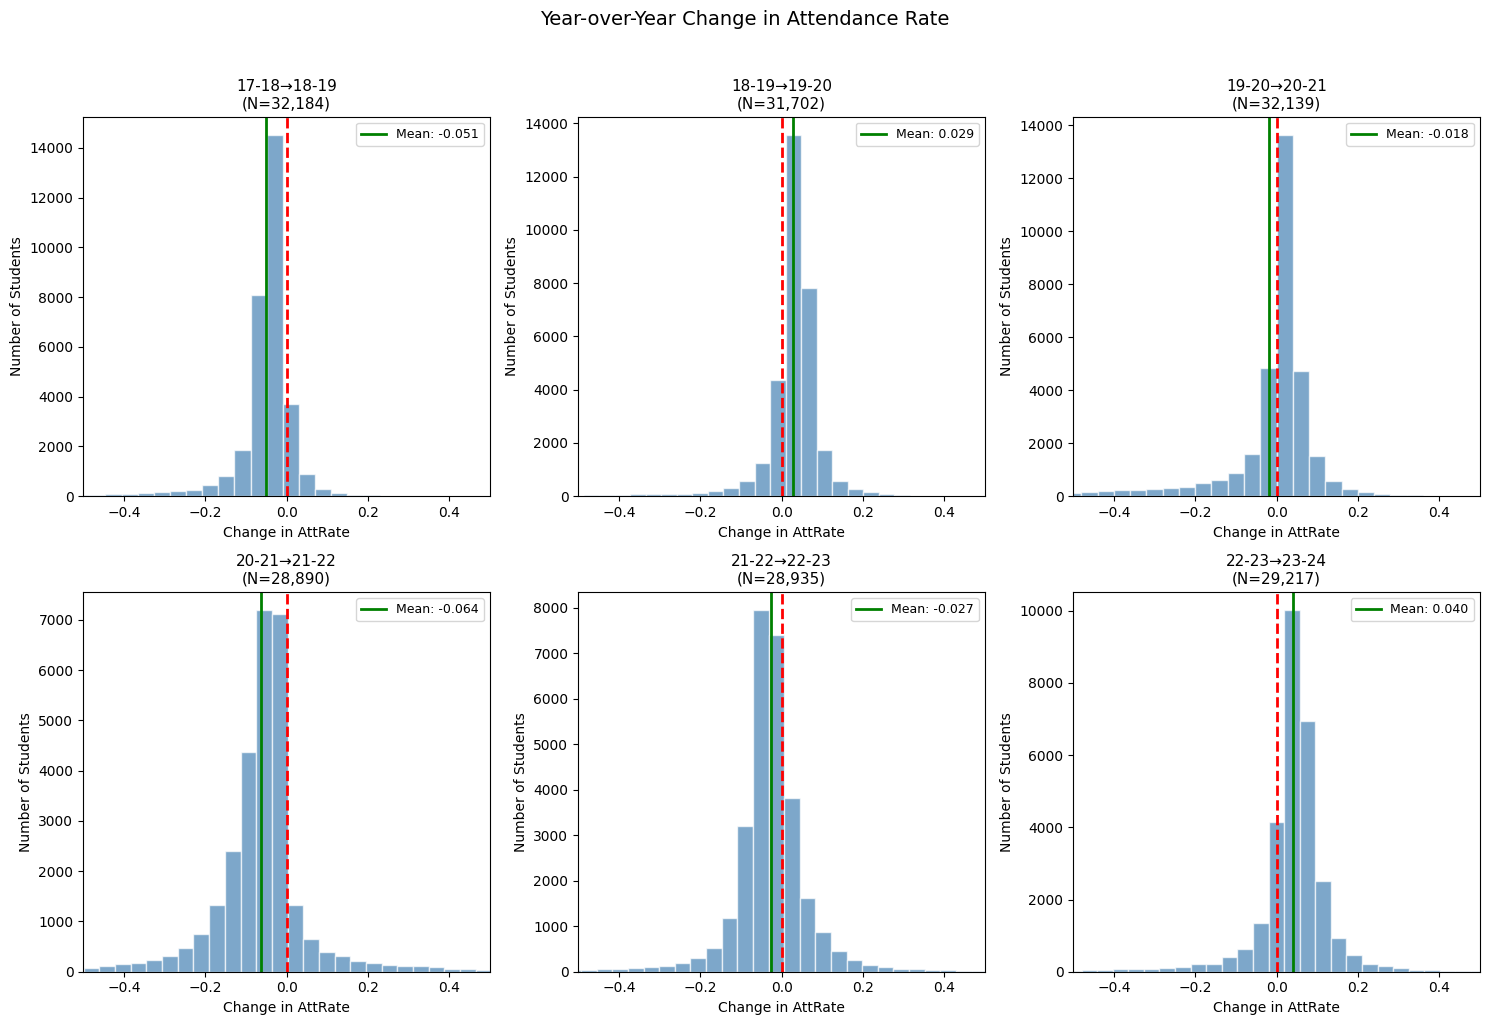


Year-over-Year Change Summary:
 Transition     N  Mean Change  Improved (%)  Declined (%)  No Change (%)
17-18→18-19 32184    -0.050869     11.086254     88.652747       0.260999
18-19→19-20 31702     0.029077     81.922276     17.860072       0.217652
19-20→20-21 32139    -0.018024     60.306792     34.101870       5.591338
20-21→21-22 28890    -0.064044     13.388716     85.105573       1.505711
21-22→22-23 28935    -0.026859     29.085882     68.664247       2.249870
22-23→23-24 29217     0.040236     81.976247     16.678646       1.345107


In [9]:
# 4. Year-over-Year Change Analysis for Individual Students
# Calculate the change in attendance rate from one year to the next

# Create wide format with just AttRate columns
df_wide = df[['ANON_ID'] + attrate_cols].copy()

# Calculate year-over-year changes
year_pairs = [('AttRate_1718', 'AttRate_1819'), ('AttRate_1819', 'AttRate_1920'), 
              ('AttRate_1920', 'AttRate_2021'), ('AttRate_2021', 'AttRate_2122'),
              ('AttRate_2122', 'AttRate_2223'), ('AttRate_2223', 'AttRate_2324')]
change_labels = ['17-18→18-19', '18-19→19-20', '19-20→20-21', '20-21→21-22', '21-22→22-23', '22-23→23-24']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

summary_data = []
for i, ((year1, year2), label) in enumerate(zip(year_pairs, change_labels)):
    # Calculate change for students with data in both years
    mask = df_wide[year1].notna() & df_wide[year2].notna()
    change = df_wide.loc[mask, year2] - df_wide.loc[mask, year1]
    
    # Summary stats
    summary_data.append({
        'Transition': label,
        'N': len(change),
        'Mean Change': change.mean(),
        'Improved (%)': (change > 0).mean() * 100,
        'Declined (%)': (change < 0).mean() * 100,
        'No Change (%)': (change == 0).mean() * 100
    })
    
    # Histogram
    axes[i].hist(change, bins=50, color='steelblue', edgecolor='white', alpha=0.7)
    axes[i].axvline(x=0, color='red', linestyle='--', linewidth=2)
    axes[i].axvline(x=change.mean(), color='green', linestyle='-', linewidth=2, label=f'Mean: {change.mean():.3f}')
    axes[i].set_xlabel('Change in AttRate', fontsize=10)
    axes[i].set_ylabel('Number of Students', fontsize=10)
    axes[i].set_title(f'{label}\n(N={len(change):,})', fontsize=11)
    axes[i].legend(fontsize=9)
    axes[i].set_xlim(-0.5, 0.5)

plt.suptitle('Year-over-Year Change in Attendance Rate', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Summary table
summary_df = pd.DataFrame(summary_data)
print("\nYear-over-Year Change Summary:")
print(summary_df.to_string(index=False))

Students with data in both 17-18 and 23-24: 11340


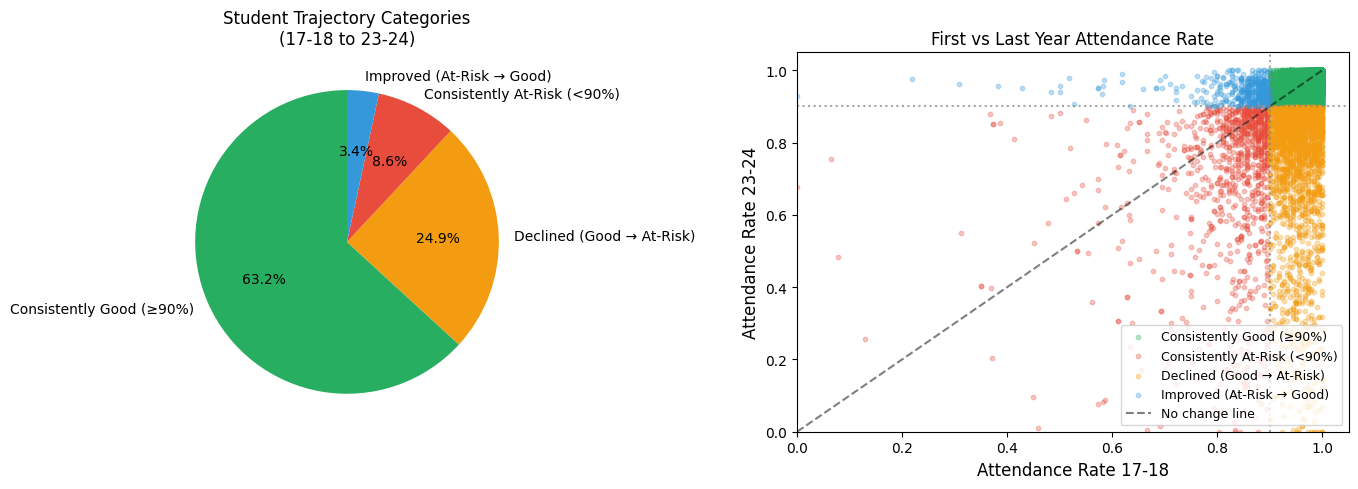


Trajectory Summary:
                             Count  Percentage
Trajectory                                    
Consistently Good (≥90%)      7166   63.192240
Declined (Good → At-Risk)     2818   24.850088
Consistently At-Risk (<90%)    973    8.580247
Improved (At-Risk → Good)      383    3.377425


In [10]:
# 5. Student Trajectory Clusters - Categorize students by their attendance patterns
# For students with data in first and last available years

# Find students with both 17-18 and 23-24 data
df_first_last = df[['ANON_ID', 'AttRate_1718', 'AttRate_2324']].dropna()
print(f"Students with data in both 17-18 and 23-24: {len(df_first_last)}")

# Categorize trajectories
def categorize_trajectory(row):
    first = row['AttRate_1718']
    last = row['AttRate_2324']
    threshold = 0.9
    
    if first >= threshold and last >= threshold:
        return 'Consistently Good (≥90%)'
    elif first < threshold and last < threshold:
        return 'Consistently At-Risk (<90%)'
    elif first >= threshold and last < threshold:
        return 'Declined (Good → At-Risk)'
    else:
        return 'Improved (At-Risk → Good)'

df_first_last['Trajectory'] = df_first_last.apply(categorize_trajectory, axis=1)

# Count and visualize
trajectory_counts = df_first_last['Trajectory'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
colors = {'Consistently Good (≥90%)': '#27ae60', 
          'Consistently At-Risk (<90%)': '#e74c3c',
          'Declined (Good → At-Risk)': '#f39c12',
          'Improved (At-Risk → Good)': '#3498db'}
axes[0].pie(trajectory_counts.values, labels=trajectory_counts.index, autopct='%1.1f%%',
            colors=[colors[x] for x in trajectory_counts.index], startangle=90)
axes[0].set_title('Student Trajectory Categories\n(17-18 to 23-24)', fontsize=12)

# Scatter plot: First vs Last year AttRate
for cat, color in colors.items():
    mask = df_first_last['Trajectory'] == cat
    axes[1].scatter(df_first_last.loc[mask, 'AttRate_1718'], 
                    df_first_last.loc[mask, 'AttRate_2324'],
                    alpha=0.3, label=cat, color=color, s=10)

axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='No change line')
axes[1].axhline(y=0.9, color='gray', linestyle=':', alpha=0.7)
axes[1].axvline(x=0.9, color='gray', linestyle=':', alpha=0.7)
axes[1].set_xlabel('Attendance Rate 17-18', fontsize=12)
axes[1].set_ylabel('Attendance Rate 23-24', fontsize=12)
axes[1].set_title('First vs Last Year Attendance Rate', fontsize=12)
axes[1].legend(loc='lower right', fontsize=9)
axes[1].set_xlim(0, 1.05)
axes[1].set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

print("\nTrajectory Summary:")
print(trajectory_counts.to_frame('Count').assign(Percentage=lambda x: x['Count']/x['Count'].sum()*100))

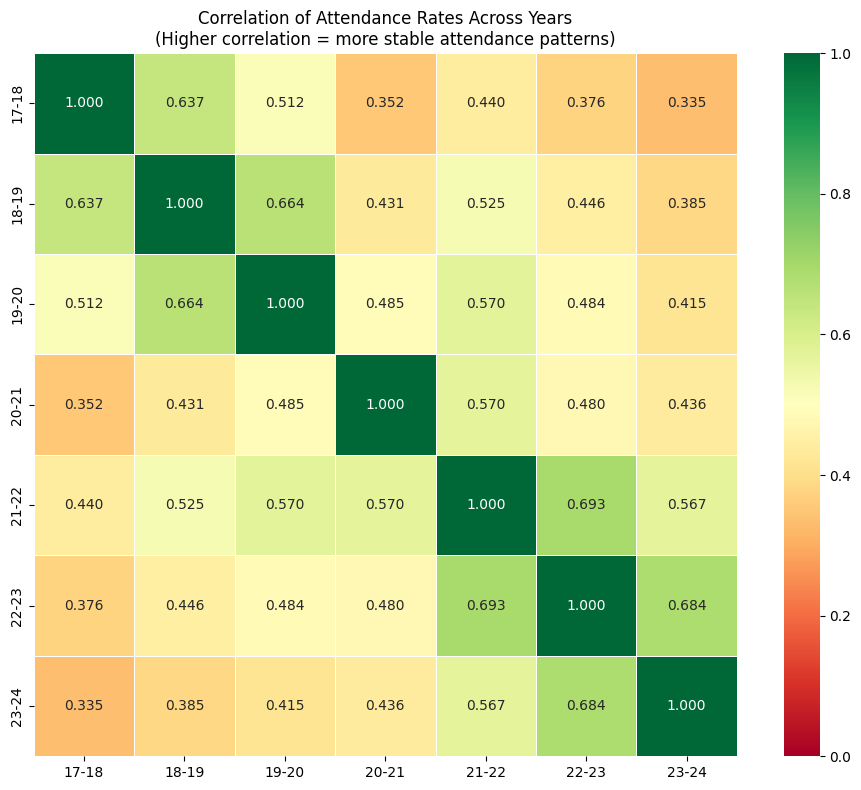


Key Insight: Adjacent years have higher correlations, suggesting attendance patterns
tend to persist but can change over longer time spans.


In [11]:
# 6. Heatmap of Attendance Rate Correlations Across Years
import seaborn as sns

# Create correlation matrix for AttRate across years
attrate_data = df[attrate_cols].copy()
attrate_data.columns = ['17-18', '18-19', '19-20', '20-21', '21-22', '22-23', '23-24']

fig, ax = plt.subplots(figsize=(10, 8))
corr_matrix = attrate_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0.5, 
            fmt='.3f', ax=ax, vmin=0, vmax=1,
            square=True, linewidths=0.5)
ax.set_title('Correlation of Attendance Rates Across Years\n(Higher correlation = more stable attendance patterns)', fontsize=12)
plt.tight_layout()
plt.show()

print("\nKey Insight: Adjacent years have higher correlations, suggesting attendance patterns")
print("tend to persist but can change over longer time spans.")

## Summary of EDA Findings

### Overall Trends:
1. **Mean attendance rate declined** from 93.5% (17-18) to a low of 84.2% (22-23), recovering to 88.9% (23-24)
2. **COVID impact visible**: Attendance dropped significantly during 20-21 and 21-22, with highest chronic absenteeism in 22-23 (58.3%)
3. **Recovery underway**: 23-24 shows improvement with 82% of students showing improved attendance vs 22-23

### Student Trajectory Patterns:
- **63.2%** maintained consistently good attendance (≥90%) from 17-18 to 23-24
- **24.9%** declined from good to at-risk status
- **8.6%** were consistently at-risk throughout
- **3.4%** improved from at-risk to good attendance

### Year-over-Year Insights:
- Largest decline: 17-18→18-19 (mean change: -5.1%) and 20-21→21-22 (mean change: -6.4%)
- Best recovery: 22-23→23-24 with 82% of students improving

### Correlation Analysis:
- Adjacent years show strong correlations (0.6-0.7), suggesting attendance patterns persist
- Correlation weakens over time (17-18 to 23-24: 0.335), indicating attendance can change over longer periods